**Importing packages that we need**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, vectorize, prange
import numba as numba
import time

**Setting up the Monte Carlo method for a NxN lattice:**

In [2]:
#function that defines that inital state for the lattice calling a random number generator
@jit()
def StateInitalize(N):
    #NXN number of spins
    Lattice = np.zeros((N,N))
    for i in range(N):
        for l in range(N):
            randNum = np.random.random()
            if randNum < 0.5:
                Lattice[i,l] = int(-1)
            else:
                Lattice[i,l] = int(1)
                
    return Lattice

**NeigbourInteraction is a function that calculates the change in energy upon flipping one spin:**

In [3]:
@jit()
def NeigbourInteraction(line,column,InitialState,LatticeSize):
    M = LatticeSize
    DeltaE = 0
    if line == int(0):#if at the top edge of lattice
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,column+1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,column-1]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line+1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line+1,column]#below
    if line == int((M-1)):#if at the bottom edge lattice
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,column+1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,column-1]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line-1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line-1,column]#below
    #Then check if at left or right edges or inside
    else:
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,column+1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,column-1]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line+1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line-1,column]#below

    DeltaE = -(Temp1 + Temp2 + Temp3 + Temp4)
    DeltaE = DeltaE*2
    #print("DeltaE is:",DeltaE)
    return DeltaE

**Function that calculates the Magnetization:**

In [4]:
@jit()
def Magnetization(Lattice):
    N,M = np.shape(Lattice)
    Magnetization = 0
    for i in range(M):#looping over lines
        for j in range(M):#looping over colums
            Magnetization += Lattice[i,j]#Adding the spin value at location i,j
            
    return Magnetization

In [6]:
#Trial of Magnetization function
LatticeA = np.array([[1,-1],[1,1]])
Magn = Magnetization(LatticeA)
print(Magn)

2


**Calculating the energy of the lattice according to the Ising model with periodic boundary conditions:**

In [7]:
@jit()
def LatticeEnergyIsing(InitialState,LatticeSize):
    #M = LatticeSize
    N,M = np.shape(InitialState)
    Energy = 0
    #print("Inital Energy:",Energy)
    for i in range(M):#loop over lines
        for j in range(M):#loop over columns
            Acceptance = (np.mod(i,2)+np.mod(j,2) == 0) or (np.mod(i,2)+np.mod(j,2) == 2)
            #print(Acceptance)
            if Acceptance:
                if (i == 0 and j == 0):#if at the top and left edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i+1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif (i == 0 and j == (M-1)):#if at the top and right edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i+1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif (i == (M-1) and j == 0):#if at the bottom and left edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif (i == (M-1) and j == (M-1)):#if at the bottom and right edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif i == 0:#if only at top edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i+1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif i == (M-1):#if only at bottom edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif j == 0:#if only at left edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif j == (M-1):#if only at right edge
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                else:#if somewhere in the middle
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                
    return Energy

In [9]:
#Trial of energy
B = np.array([[1,1],[1,1]])
print(B)
EnergyTrial = LatticeEnergyIsing(B,2)
print("The energy according to Ising Model:", EnergyTrial)

[[1 1]
 [1 1]]
The energy according to Ising Model: -8


**Metropolis part:**

In [10]:
@jit()
def Metropolis(DeltaEnergy,Temperature):
    Accept = False
    Exp1 = np.exp(-(1/Temperature)*(-8))
    Exp2 = np.exp(-(1/Temperature)*(-4))
    Exp3 = 1
    Exp4 = np.exp(-(1/Temperature)*(4))
    Exp5 = np.exp(-(1/Temperature)*(8))
    if DeltaEnergy < 0:
        Accept = True
    else:
        randNum = np.random.random()
        if DeltaEnergy == -8:
            w = Exp1
        elif DeltaEnergy == -4:
            w = Exp2
        elif DeltaEnergy == 0:
            w = Exp3
        elif DeltaEnergy == 4:
            w = Exp4
        else:
            w = Exp5
        #Checking w agains the exponent and accepting if r <= w
        if randNum <= w:
            Accept = True
        else:
            Accept = False
            
    return Accept

**The Monte Carlo calculation itself:**

In [64]:
@jit(nopython=True)
def MonteCarloIsing(InitialState1,NumOfCycles,LatticeSize,Temperature):
    EnergyVector = np.zeros(NumOfCycles-80001)
    MagnetizationVector = np.zeros(NumOfCycles-80001)
    M = LatticeSize
    NSpins = M*M#Number of spins
    EnergyMatrix = InitialState1
    InitialState = InitialState1#Setting a lattice for overwriting
    #Calculating the initial energy
    Energy = LatticeEnergyIsing(EnergyMatrix,M)
    #print(Energy)
    MC = NumOfCycles
    SkipCycles = 80001#Number of cycles to skip for the system to reach its most likely state
    CounterAcceptance = 0#Counter to see how many moves are accepted
    EnergyValue = 0
    EnergyValueSquared = 0
    MagnValue = 0
    MagnValueSquared = 0
    MagnValueAbs = 0
    norm = 1/MC
    T = Temperature
    counter = 0
    for i in range(MC):#Looping over the number of MC cycles
        #picking a random coordinate in the lattice
        randNum = np.random.randint(M*M)
        line = int(np.floor(randNum/M))#finding the relavant line in the lattice
        column = int(randNum - M*line)#finding the relavant column in the lattice
        #print(randNum,line,column)
        #flipping the spin at that position
        TempState = InitialState.copy()
        #print(InitialState[line,column])
        #print(InitialState)
        if InitialState[line,column] == 1:
            TempState[line,column] = int(-1)
            tempValue = int(-1)#setting temp value to the assign to the system if move is accepted
        else:
            TempState[line,column] = int(1)
            tempValue = int(1)#setting temp value to the assign to the system if move is accepted
        #finding the difference in energy - using periodic boundary conditions
        DeltaE = NeigbourInteraction(line,column,TempState,M)
        Acceptance = Metropolis(DeltaE,T)
        #Metropolis part
        if Acceptance:
            InitialState[line,column] = tempValue
            CounterAcceptance += 1  
        #Appending Energy and other relevant variables for calculations
        Energy = LatticeEnergyIsing(InitialState,M)#Þarf að taka alltaf gildin á orkunni!!!
        if i > 80000:#Accounting for time that it takes to reach the most likely state
            EnergyVector[counter] = Energy
            EnergyValue += Energy
            EnergyValueSquared += Energy**2
            #Magnetization
            MagnetiZ = Magnetization(InitialState)
            MagnetizationVector[counter] = MagnetiZ
            MagnValue += MagnetiZ
            MagnValueSquared += MagnetiZ**2
            MagnValueAbs += abs(MagnetiZ)
            counter += 1
        #End of MC loop

    #print(InitialState)
    MC = MC - SkipCycles
    #print(Energy)
    FinalEnergy = LatticeEnergyIsing(InitialState,M)
    #Calculating average energy per particle
    #TotalEnergy = sum(EnergyVector)
    AverageEnergy = EnergyValue/MC
    AverageEnergySquared = EnergyValueSquared/MC
    #Energy per spin
    EnergyPerParticle = AverageEnergy/NSpins
    #Variance in Energy
    EnergyVariancePerSpin = (AverageEnergySquared - AverageEnergy**2)/NSpins
    #Specific Heat - SPURNING hvað ég að nota fyrir Boltzmanns fasta
    k = 1
    SpecificHeat = (1/(k*(T**2)))*EnergyVariancePerSpin
    #Magnetization
    AverageMagnetization = MagnValue/MC
    AverageMagnetizationPerPar = AverageMagnetization/NSpins
    AverageMagnetizationSquared = MagnValueSquared/MC
    AverageMagnetizationAbs = MagnValueAbs/MC
    AverageMagnetizationAbsPerSpin = AverageMagnetizationAbs/NSpins
    #Variance in Magnetization
    MagnetizationVariancePerSpin = (AverageMagnetizationSquared - AverageMagnetization**2)/(NSpins)
    #Susceptibility
    Susceptibility = (1/(k*T))*MagnetizationVariancePerSpin

    return CounterAcceptance, EnergyVector, EnergyPerParticle, AverageMagnetizationPerPar, AverageMagnetizationAbsPerSpin, SpecificHeat, Susceptibility

## Parallelized Monte Carlo:

**Eitthvað sem fer vel úr skorðum við útreikninga!!! Möguleg lausn að kalla á gamla fallið sem gerir alla útreikninga og annað yfirfall sem sér bara um að skipta á milli þráða samkvæmt hitastigi**

In [39]:
@jit(nopython=True,parallel=True)
def MonteCarloIsingParallel(InitialState1,NumOfCycles,LatticeSize,Temperature,Time):
    EnergyVector = np.zeros(NumOfCycles-80001)
    MagnetizationVector = np.zeros(NumOfCycles-80001)
    M = LatticeSize
    NSpins = M*M#Number of spins
    EnergyMatrix = InitialState1
    InitialState = InitialState1#Setting a lattice for overwriting
    #Calculating the initial energy
    Energy = LatticeEnergyIsing(EnergyMatrix,M)
    #print(Energy)
    MC = NumOfCycles
    SkipCycles = 80001#Number of cycles to skip for the system to reach its most likely state
    CounterAcceptance = np.zeros(len(Temperature))#Counter to see how many moves are accepted
    EnergyValue = np.zeros(len(Temperature))
    EnergyValueSquared = np.zeros(len(Temperature))
    MagnValue = np.zeros(len(Temperature))
    MagnValueSquared = np.zeros(len(Temperature))
    MagnValueAbs = np.zeros(len(Temperature))
    norm = 1/MC
    #Parallelization
    counter = np.zeros(len(Temperature))
    T = Temperature
    for j in prange(len(Temperature)):
        np.random.seed(Time*(j+1))#Seeding differently for each thread if they start at the same time
        tempTemp = T[j]
        for i in range(MC):#Looping over the number of MC cycles
            #picking a random coordinate in the lattice
            randNum = np.random.randint(M*M)
            line = int(np.floor(randNum/M))#finding the relavant line in the lattice
            column = int(randNum - M*line)#finding the relavant column in the lattice
            #print(randNum,line,column)
            #flipping the spin at that position
            TempState = InitialState.copy()
            #print(InitialState[line,column])
            #print(InitialState)
            if InitialState[line,column] == 1:
                TempState[line,column] = int(-1)
                tempValue = int(-1)#setting temp value to the assign to the system if move is accepted
            else:
                TempState[line,column] = int(1)
                tempValue = int(1)#setting temp value to the assign to the system if move is accepted
            #finding the difference in energy - using periodic boundary conditions
            DeltaE = NeigbourInteraction(line,column,TempState,M)
            Acceptance = Metropolis(DeltaE,tempTemp)
            #Metropolis part
            if Acceptance:
                InitialState[line,column] = tempValue
                CounterAcceptance[j] += 1  
            #Appending Energy and other relevant variables for calculations
            Energy = LatticeEnergyIsing(InitialState,M)#Þarf að taka alltaf gildin á orkunni!!!
            if i > 80000:#Accounting for time that it takes to reach the most likely state
                #EnergyVector[counter] = Energy
                EnergyValue[j] += Energy
                EnergyValueSquared[j] += Energy**2
                #Magnetization
                MagnetiZ = Magnetization(InitialState)
                #MagnetizationVector[counter] = MagnetiZ
                MagnValue[j] += MagnetiZ
                MagnValueSquared[j] += MagnetiZ**2
                MagnValueAbs[j] += np.absolute(MagnetiZ)
                counter[j] += 1
            #End of MC loop

    #print(InitialState)
    MC = MC - SkipCycles
    #print(Energy)
    #FinalEnergy = LatticeEnergyIsing(InitialState,M)
    #Calculating average energy per particle
    #TotalEnergy = sum(EnergyVector)
    AverageEnergy = EnergyValue/MC
    AverageEnergySquared = EnergyValueSquared/MC
    #Energy per spin
    EnergyPerParticle = AverageEnergy/NSpins
    #Magnetization
    AverageMagnetization = MagnValue/MC
    AverageMagnetizationPerPar = AverageMagnetization/NSpins
    AverageMagnetizationSquared = MagnValueSquared/MC
    AverageMagnetizationAbs = MagnValueAbs/MC
    AverageMagnetizationAbsPerSpin = AverageMagnetizationAbs/NSpins
    #Calculating the rest
    EnergyVariancePerSpin = np.zeros(len(T))
    #SpecificHeat = np.zeros(len(T))
    MagnetizationVariancePerSpin = np.zeros(len(T))
    Susceptibility = np.zeros(len(T))
    #for i in range(len(T)):#Eitthvað flipp í gangi hér!!
    #Variance in Energy
    EnergyVariancePerSpin = (AverageEnergySquared - AverageEnergy**2)/NSpins
    #Variance in Magnetization
    MagnetizationVariancePerSpin = (AverageMagnetizationSquared - AverageMagnetization**2)/(NSpins)
    #Specific Heat - SPURNING hvað ég að nota fyrir Boltzmanns fasta
    k = 1
    SpecificHeat = (1/(k*(T**2)))*EnergyVariancePerSpin
    #Susceptibility
    Susceptibility = (1/(k*T))*MagnetizationVariancePerSpin

    return CounterAcceptance, EnergyVector, EnergyPerParticle, AverageMagnetizationPerPar, AverageMagnetizationAbsPerSpin, SpecificHeat, Susceptibility

**Alternative MC parallelized:**

In [89]:
@jit(nopython=True,parallel=True)
def MonteCarloIsingParallel2(State,NumOfCycles,L,Temperature,Time):
    #Calling the original MCIsing with Temperature Parallized
    T = Temperature
    CounterAccept = np.zeros(len(T))
    EnergyPerPart = np.zeros(len(T))
    AverageMagnPerPart = np.zeros(len(T))
    AverageMagnPerPartAbs = np.zeros(len(T))
    SpecificHeat = np.zeros(len(T))
    Susceptibility = np.zeros(len(T))
    for i in prange(len(T)):
        np.random.seed(Time*(i+1))#Seeding differently for each thread if they start at the same time
        #Calling the original MC Ising
        TempState = State.copy()
        CountAcc, EnergyVec, EnPerPa, AvMagnPePa, AvMagnPePaAbs, SpeHeat, Susc = MonteCarloIsing(TempState,NumOfCycles,L,T[i])
        CounterAccept[i] = CountAcc
        EnergyPerPart[i] = EnPerPa
        AverageMagnPerPart[i] = AvMagnPePa
        AverageMagnPerPartAbs[i] = AvMagnPePaAbs
        SpecificHeat[i] = SpeHeat
        Susceptibility[i] = Susc
        
    return CounterAccept, EnergyPerPart, AverageMagnPerPart, AverageMagnPerPartAbs, SpecificHeat, Susceptibility

In [73]:
#Trial of New Parallized MC
Time = time.time()
L = 20
StateP = StateInitalize(L)
TempRange = np.arange(0.2,2,0.1)
#TempRange = np.array([1])
print(TempRange)
start = time.time()
AcceptedMovesP, EnergyPerPartP, AverageMagnP, AverageMagnAbsP, SpecificHeatP, SusceptibilityP = MonteCarloIsingParallel2(StateP,1000000,L,TempRange,Time)
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMovesP)
print("Energy per particle:",EnergyPerPartP)
print("The Average magnetization per spin is:",AverageMagnP)
print("The Average absolute magnetization per spin is",AverageMagnAbsP)
print("The Specific Heat is:",SpecificHeatP)
print("The Susceptibility is:",SusceptibilityP)

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9]
-1.9579186933898842 -0.8719521053827232
-1.9645740049717446 -0.9897961139088194
-1.9972606981094545 -0.9992723905134678
-2.0 -1.0
-1.8608715661647457 -0.6278924868396596
-1.9481792371513447 0.9842884068352248
-2.0 -1.0
-1.9928836118300128 -0.9980122532741883
-1.9996024723939916 -0.999899070542468
-1.9242141621893065 -0.9763812188926292
-1.9873019046759834 -0.9965542951677121
-2.0 -1.0
-1.9987800693261624 -0.999675939865152
-1.8888492922274915 0.9635274603559352
-1.9790272435078733 -0.9940991457599411
-1.7946118528389703 0.17995436408083051
-1.8501900871631383 -0.9503195329560141
-1.789643662656155 0.9160271750295381
The measurement took, in seconds: 25.56398916244507
Number of Accepted moves: [  938.   702.  1730.  4218.  2520. 10134.   918.  1608.  1656.  3444.
  4398.  6729. 12891. 18167. 22836. 36429. 48652. 68540.]
Energy per particle: [-2.         -2.         -2.         -1.79461185 -1.95791869 -1.86087157
 

In [43]:
#Trial of Parallized MC
Time = time.time()
StateP = StateInitalize(2)
TempRange = np.arange(0.2,2,0.1)
#TempRange = np.array([1])
print(TempRange)
start = time.time()
AcceptedMovesP, EnergyAllP, EnergyPerPartP, AverageMagnP, AverageMagnAbsP, SpecificHeatP, SusceptibilityP = MonteCarloIsingParallel(StateP,1000000,2,TempRange,Time)
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMovesP)
print("Energy per particle:",EnergyPerPartP)
print("The Average magnetization per spin is:",AverageMagnP)
print("The Average absolute magnetization per spin is",AverageMagnAbsP)
print("The Specific Heat is:",SpecificHeatP)
print("The Susceptibility is:",SusceptibilityP)

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9]
The measurement took, in seconds: 3.011178493499756
Number of Accepted moves: [17742. 29409. 40502. 55464. 18049. 29994. 41055. 56070. 18363. 31436.
 44014. 58754. 22681. 35395. 48852. 68708. 66588. 82722.]
Energy per particle: [-1.95356625 -1.92459122 -1.89674771 -1.85971506 -1.95236625 -1.9242184
 -1.89438902 -1.85986724 -1.95312386 -1.92273687 -1.89175423 -1.85827485
 -1.94835973 -1.91969665 -1.88721727 -1.84173026 -1.86769877 -1.8342346 ]
The Average magnetization per spin is: [ 5.09239684e-04  9.32446666e-03  2.57647019e-02 -1.86706725e-02
 -1.25000136e-05  2.36157865e-02  2.02560003e-02 -8.13479145e-03
  4.67772248e-03  1.08108813e-02  9.88968466e-03 -6.46305050e-03
  6.54457233e-03  1.43233851e-02  1.16902301e-02 -8.89566184e-03
 -5.97826737e-04  4.77283127e-03]
The Average absolute magnetization per spin is [0.98533966 0.976294   0.96752225 0.95587713 0.98496574 0.97610269
 0.96670377 0.95585756 0.9852548

**Trying the algo:**
Gera 2x2 case þannig að ég tel frá byrjun!!!

In [21]:
A = StateInitalize(2)
start = time.time()
AcceptedMoves, EnergyAll, EnergyPerPart, AverageMagn, AverageMagnAbs, SpecificHeat, Susceptibility = MonteCarloIsing(A,1000000,2,1)
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMoves)
print("Energy per particle:",EnergyPerPart)
print("The Average magnetization per spin is:",AverageMagn)
print("The Average absolute magnetization per spin is",AverageMagnAbs)
print("The Specific Heat is:",SpecificHeat)
print("The Susceptibility is:",Susceptibility)#Susceptibility measurement looks strange!!

The measurement took, in seconds: 0.4340066909790039
Number of Accepted moves: 1759
Energy per particle: -1.9966956485822267
The Average magnetization per spin is: -0.11957567345181896
The Average absolute magnetization per spin is 0.998899455325495
The Specific Heat is: 0.02639113638901769
The Susceptibility is: 3.9373011925073924


**Plotting the energy as a function of MC steps:**

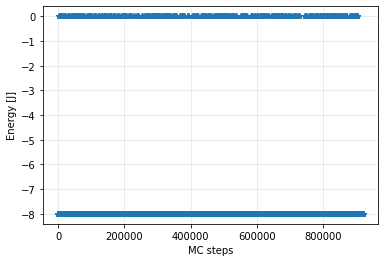

In [22]:
fig, ax = plt.subplots()
Steps = np.arange(0,1000000-80001)
ax.plot(Steps,EnergyAll,'*')
ax.set_xlabel("MC steps")
ax.set_ylabel("Energy [J]")
ax.grid(alpha=0.3)
plt.show()

**Trial for bigger lattice:**

In [58]:
A2 = StateInitalize(20)
start = time.time()
AcceptedMoves2, EnergyAll2, EnergyPerPart2, AverageMagn2, AverageMagnAbs2,SpecificHeat2, Susceptibility2 = MonteCarloIsing(A2,1000000,20,1)
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMoves2)
print("Energy per particle:",EnergyPerPart2)
print("The Average magnetization is:",AverageMagn2)
print("The Averaga absolute magnetization is:",AverageMagnAbs2)
print("The Specific Heat is:",SpecificHeat2)
print("The Susceptibility is:", Susceptibility2)

The measurement took, in seconds: 2.4031732082366943
Number of Accepted moves: 1868
Energy per particle: -1.997324056873975
The Average magnetization is: 0.9992934340146021
The Averaga absolute magnetization is: 0.9992934340146021
The Specific Heat is: 0.022801139686489478
The Susceptibility is: 0.0016529599910427351


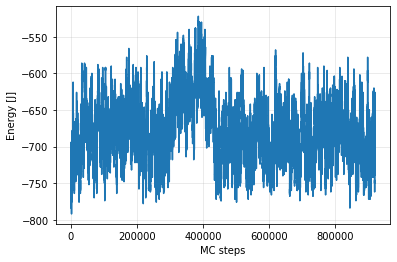

In [24]:
fig2, ax2 = plt.subplots()
Steps2 = np.arange(0,1000000-80001)
ax2.plot(Steps2,EnergyAll2)
ax2.set_xlabel("MC steps")
ax2.set_ylabel("Energy [J]")
ax2.grid(alpha=0.3)#Eitthvað abnormalitiy í lokin!!!
plt.show()

**We see that the system has reached its most likely state after at least 80000 iterations, but often quite lower. Thus we start to take measurements after 80000 iterations for analysis.**

**Let's do measurements for several different Temperature:**

2.2041046619415283
2.47882342338562
2.195523977279663
2.220167636871338
2.196187973022461
2.2446696758270264
2.289799690246582
3.167296886444092
2.4891843795776367
3.5488288402557373
2.5402185916900635
2.9357118606567383
2.7071938514709473
2.5123684406280518
2.409299850463867
2.3613083362579346
2.337552785873413
2.313279390335083
2.4682319164276123
2.311919689178467
2.288526773452759
2.3238399028778076
2.383549928665161
2.398573160171509
2.3485233783721924
3.608905553817749
2.3992645740509033
2.3471145629882812
2.4306447505950928
2.3927130699157715
2.7332065105438232
2.3959007263183594
2.4458718299865723
4.529515266418457
2.5357940196990967
2.7666239738464355
2.518165349960327
2.351426124572754
2.6516213417053223
2.6435952186584473
2.6121418476104736
2.8060975074768066
2.3883309364318848
2.476022243499756
2.550145387649536
2.4581398963928223
2.358994245529175
2.736621618270874
2.494142770767212
2.293806314468384


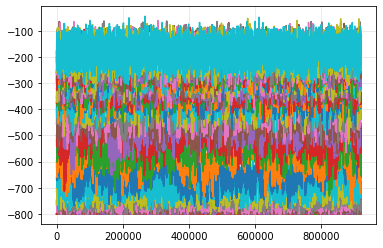

In [94]:
#T = [0.1,0.3,0.5,0.7,0.9,1,1.3,1.5,1.7,1.9,2,2.3,2.5,2.7,2.9,3]
T = np.arange(0.1,5.1,0.1)
MC_Cycles = int(1e6)
Steps3 = np.arange(0,MC_Cycles-80001)
AcceptedMoves = np.zeros(len(T))
EnergyPerParticle = np.zeros(len(T))
MagnetizationPerParticle = np.zeros(len(T))
Susceptibility = np.zeros(len(T))
SpecificHeat = np.zeros(len(T))
fig3, ax3 = plt.subplots()
counter = 0
L = 20#Lattice size
for i in range(len(T)):
    Temp = T[i]
    A3 = StateInitalize(L)
    start = time.time()
    AcceptedMoves2, EnergyAll2, EnergyPerPart2, AverageMagn2, AverageMagnAbs2,SpecificHeat2, Susceptibility2 = MonteCarloIsing(A3,MC_Cycles,L,Temp)
    end = time.time()
    print(end-start)
    EnergyPerParticle[counter] = EnergyPerPart2
    SpecificHeat[counter] = SpecificHeat2
    MagnetizationPerParticle[counter] = AverageMagnAbs2
    Susceptibility[counter] = Susceptibility2
    counter += 1
    ax3.plot(Steps3,EnergyAll2)
    
ax3.grid(alpha=0.3)
plt.show()

**Energy per particle as a function of temperature:**

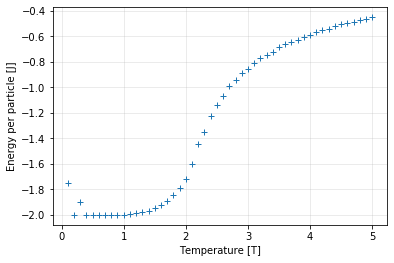

In [95]:
#Plotting energy as a function of particle
fig4,ax4 = plt.subplots()
ax4.plot(T,EnergyPerParticle,'+')
ax4.set_ylabel("Energy per particle [J]")
ax4.set_xlabel("Temperature [T]")
ax4.grid(alpha=0.3)
plt.show()

**Specific heat as a function of temperature:**

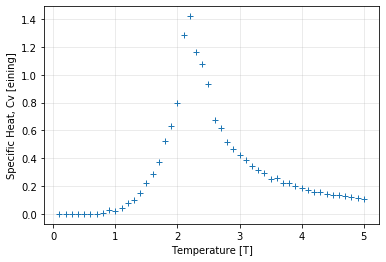

In [96]:
#Plotting specific heat as a function of Temperature - Eitthvað mjög flippað í gangi hér !!
fig5,ax5 = plt.subplots()
ax5.plot(T,SpecificHeat,'+')
ax5.set_ylabel("Specific Heat, Cv [eining]")
ax5.set_xlabel("Temperature [T]")
ax5.grid(alpha=0.3)
plt.show()

**Average Magnetization as a function of particle:**

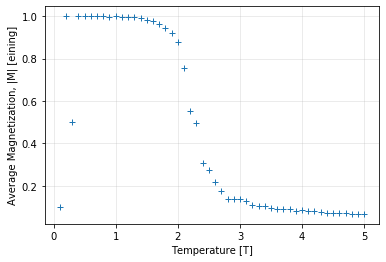

In [97]:
#Plotting average Magnetization as a function of temperature
fig6,ax6 = plt.subplots()
ax6.plot(T,MagnetizationPerParticle,'+')
ax6.set_ylabel("Average Magnetization, |M| [eining]")
ax6.set_xlabel("Temperature [T]")
ax6.grid(alpha=0.3)
plt.show()

**Accurate measurements around $T_C$:** Eitthvað mjög flippað í gangi, held með parallelization!!!!

In [90]:
#Trial of Parallized MC
L = 40
StateP = StateInitalize(L)
TempRange = np.arange(0.2,4,0.1)
print(TempRange)
Time = time.time()
start = time.time()
AcceptedMovesP, EnergyPerPartP, AverageMagnP, AverageMagnAbsP, SpecificHeatP, SusceptibilityP = MonteCarloIsingParallel2(StateP,2000000,L,TempRange,Time)
end = time.time()
print("The measurement took, in seconds:", end-start)
print("Number of Accepted moves:",AcceptedMovesP)
print("Energy per particle:",EnergyPerPartP)
print("The Average magnetization per spin is:",AverageMagnP)
print("The Average absolute magnetization per spin is",AverageMagnAbsP)
print("The Specific Heat is:",SpecificHeatP)
print("The Susceptibility is:",SusceptibilityP)

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9
 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7
 3.8 3.9]
The measurement took, in seconds: 355.06412410736084
Number of Accepted moves: [   9608.   11322.   13518.   14514.    9712.   10684.   31982.   13002.
   12686.   26335.   69440.   34411.   84993.   60686.   63026.  149921.
  154763.  190240.  239636.  254285.  362421.  467497.  550145.  628911.
  708132.  763122.  814496.  864800.  912562.  946995.  983876. 1019227.
 1050966. 1079725. 1110361. 1134586. 1158887. 1181579.]
Energy per particle: [-1.9863111  -1.896022   -1.97121802 -1.92925594 -1.98712943 -1.98551203
 -1.92533207 -1.98277776 -1.98354685 -1.95139657 -1.85305245 -1.94533701
 -1.84734595 -1.90349606 -1.90454063 -1.75500204 -1.75535821 -1.70510704
 -1.63408265 -1.62157044 -1.46792771 -1.32911622 -1.22333443 -1.13090652
 -1.03798037 -0.98007929 -0.92861615 -0.87726899 -0.82891416 -0.79724724
 -0.76356938 -0.72827598 -0.700

**Plotting the relevant Parameters:**

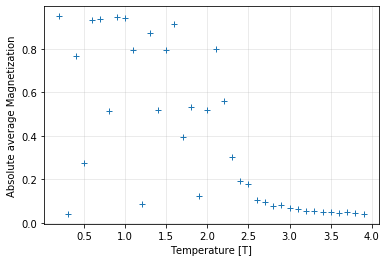

In [91]:
fig7, ax7 = plt.subplots()
ax7.plot(TempRange,AverageMagnAbsP,'+')
ax7.set_ylabel("Absolute average Magnetization")
ax7.set_xlabel("Temperature [T]")
ax7.grid(alpha=0.3)

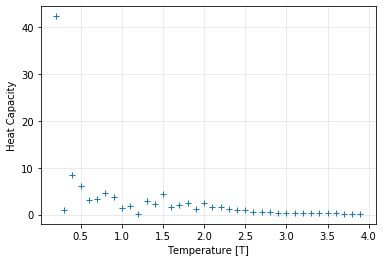

In [92]:
#Heat capacity
fig8, ax8 = plt.subplots()
ax8.plot(TempRange,SpecificHeatP,'+')
ax8.set_ylabel("Heat Capacity")
ax8.set_xlabel("Temperature [T]")
ax8.grid(alpha=0.3)

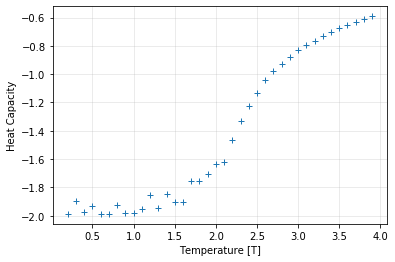

In [93]:
#Energy per Particle
fig9, ax9 = plt.subplots()
ax9.plot(TempRange,EnergyPerPartP,'+')
ax9.set_ylabel("Heat Capacity")
ax9.set_xlabel("Temperature [T]")
ax9.grid(alpha=0.3)